In [1]:
from pathlib import Path
import IPython.display as ipd

import torch
import torchaudio
import numpy as np

import muspy
import pypianoroll as pypir

from utils import pianoroll2binaryroll, binaryroll2pitchlist, pitchlist2pianoroll, shortpitchlist2pitchlist, pitchlist2shortpitchlist
from utils import UNIT_AS_TICK, BEAT_AS_TICK, BAR_AS_TICK
from utils import relative_semitones_major, relative_semitones_minor

from dataset import BluesPairSet

PATH_PREFIX = 'data_set/'
PATH_PREFIX_Q = 'quantized/'

In [2]:
dataset = BluesPairSet()

100%|██████████| 104/104 [00:08<00:00, 12.75it/s]


In [3]:
data_dir = Path(PATH_PREFIX_Q)
data_list = sorted(list(data_dir.rglob('*.mid')))

['jamin_for_doc_doc_bomi-4|4-120-001-4-c.mid', 'jamin_for_doc_doc_bomi-4|4-120-001-4-r.mid']


[<Axes: xlabel='time (beat)', ylabel='\n\npitch'>]

[<Axes: xlabel='time (beat)', ylabel='\n\npitch'>]

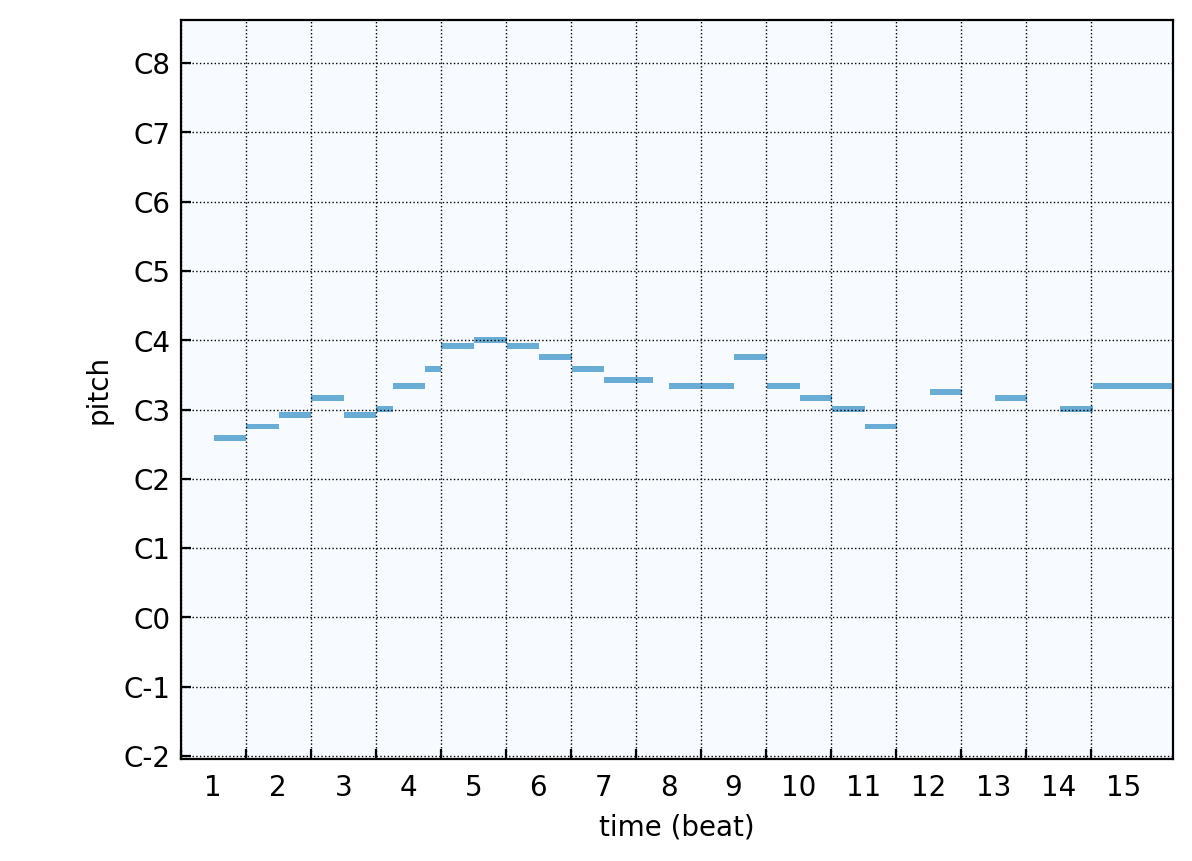

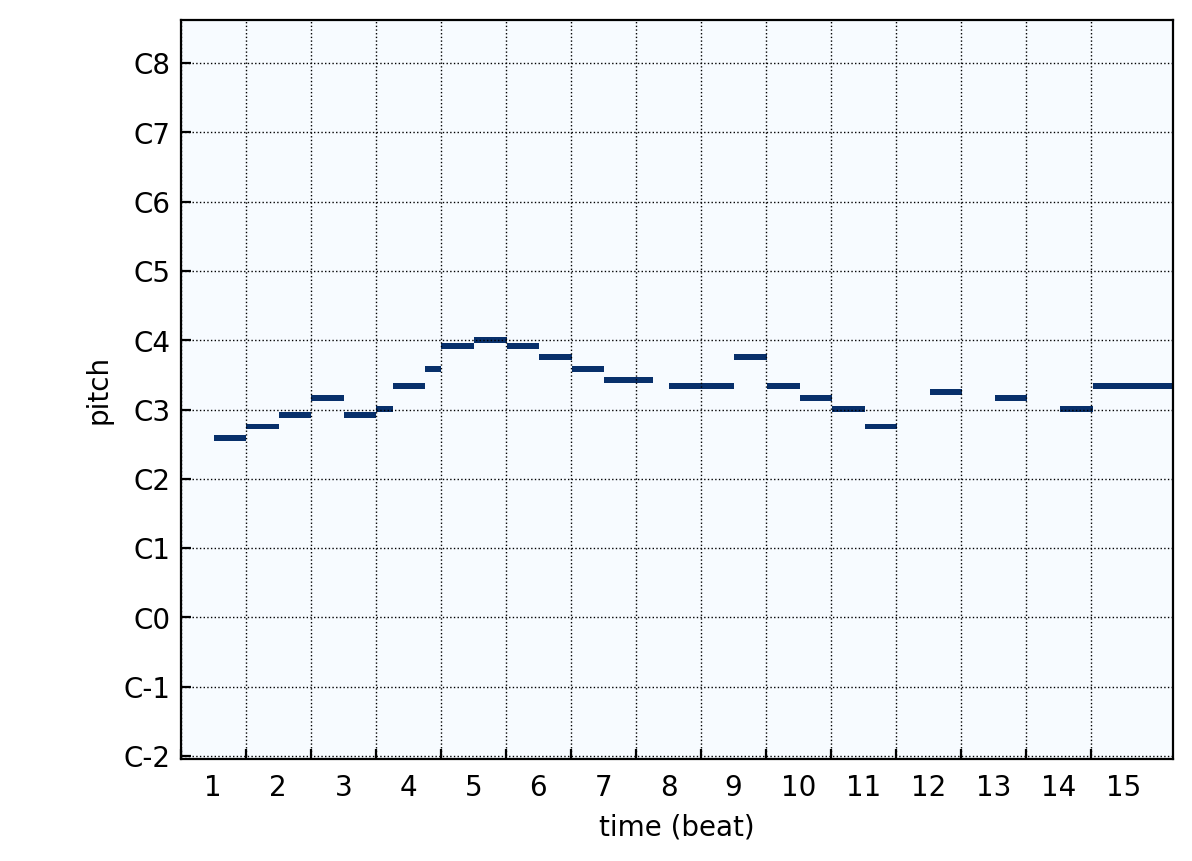

In [11]:
pair = data_list[30:32]
from_dataset = dataset[15]

print([file.name for file in pair])

midis = [muspy.read(data_path) for data_path in pair]


dataset_pitch_list = [[dataset.idx2token[idx] for idx in ls] for ls in from_dataset]
dataset_pitch_list = [[item for item in ls if item != '<pad>' and item != '<start>' and item != '<end>'] for ls in dataset_pitch_list]

dataset_pitch_list = [shortpitchlist2pitchlist(spl) for spl in dataset_pitch_list]
dataset_pianorolls = [pitchlist2pianoroll(pl) for pl in dataset_pitch_list]


pianoroll_objs = [muspy.to_pypianoroll(midi) for midi in midis]
dataset_pianoroll_objs = [obj.copy() for obj in pianoroll_objs]

for idx, obj in enumerate(dataset_pianoroll_objs):
    obj.tracks[0].pianoroll = dataset_pianorolls[idx]


ipd.display(pianoroll_objs[0].plot())
ipd.display(dataset_pianoroll_objs[0].plot())

In [72]:
DEVICE = 'cuda'

def collate(raw_batch):
    call_list = []
    res_list = []
    
    for pair in raw_batch:
        call_list.append(pair[0])
        res_list.append(pair[1])
        
    call_list = [item.to(DEVICE) for item in call_list]
    res_list = [item.to(DEVICE) for item in res_list]
    
    return torch.stack(call_list), torch.stack(res_list)

trainset, validset = torch.utils.data.random_split(dataset, [42, 10])
train_loader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, collate_fn=collate)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=10, shuffle=False, collate_fn=collate)

for batch in train_loader:
    call, res = batch
    print(call.is_cuda)
    break

True


<class 'torch.Tensor'>
16
torch.Size([16, 68])
False
